# Simplifying network by merging nodes and then connecting edges
### Looks like its working fine as it should!

In [28]:
import pickle
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import pandas as pd
import itertools
import warnings
from shapely.geometry import LineString
from shapely.geometry import Point
from tqdm import tqdm
from geopy.distance import great_circle as distance
from geopy.distance import distance
from itertools import islice
import matplotlib.pyplot as plt 

import graph simplified only with shorten_edgesv2 (base graph):

In [29]:
# Import the simplified network from previous step:
with open("/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling/Simplified_ShortenEdgesv2.pickle", 'rb') as file:
    P = pickle.load(file)

Plot base graph:

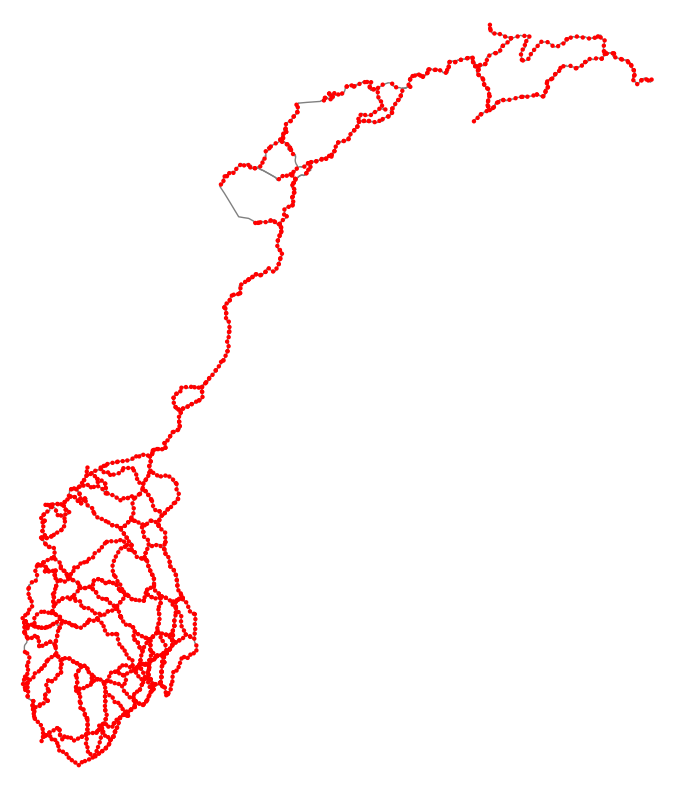

Graph before additional simplification.


In [92]:
ox.plot_graph(P, figsize = (10, 10), node_color="red", edge_color = "gray", bgcolor = "white", node_size=10, edge_linewidth = 1)
print('Graph before additional simplification.')

Make *GeoDataFrames* from base graph:

In [60]:
# Store node attributes in a dictionary
node_attrs = {}
for node, attrs in P.nodes(data=True):
    node_attrs[node] = attrs

# Create a DataFrame from the node attributes
base_node_df = pd.DataFrame.from_dict(node_attrs, orient='index')

# Convert the edge data to a pandas DataFrame
base_edge_data = P.edges(data=True)
base_edge_df = pd.DataFrame(base_edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
base_edge_df = pd.concat([base_edge_df.drop('data_dict', axis=1), base_edge_df['data_dict'].apply(pd.Series)], axis=1)

# create geometry points from x and y columns
geometry = [Point(xy) for xy in zip(base_node_df['x'], base_node_df['y'])]
# add geometry column to dataframe
base_node_df['geometry'] = geometry
base_nodes_gdf = gpd.GeoDataFrame(base_node_df, geometry="geometry")
base_edges_gdf = gpd.GeoDataFrame(base_edge_df, geometry="geometry")

base_nodes_gdf.crs = {'init': 'epsg:4326'}
base_edges_gdf.crs = {'init': 'epsg:4326'}

display(base_nodes_gdf.head())
display(base_edges_gdf.head())

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,x,y,osmid,roadclass,isBridge,isTunnel,elevation,OD,CS,geometry
794436,10.733793,59.909994,794436,0,0,1,2.351,1,0,POINT (10.73379 59.90999)
1393791,10.567168,59.897329,1393791,0,0,0,14.172,0,0,POINT (10.56717 59.89733)
1393835,10.558760,59.895747,1393835,0,0,0,13.054,0,1,POINT (10.55876 59.89575)
1394577,10.442084,59.834063,1394577,0,0,0,106.972,0,0,POINT (10.44208 59.83406)
1432666,10.303187,59.811314,1432666,0,0,0,239.617,0,1,POINT (10.30319 59.81131)


,source,target,id,oneway,ref,name,funcroadclass,roadclass,isFerry,isBridge,...,speedlim,drivetime,length,length_weight,geometry,u,v,grade,grade_abs,artificial
0,794436,1393791,"[794436, 1393791]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]",...,"[80, 50, 70]",-89.335117,10185.310131,"[484.21732318058076, 67.01337679355969, 13.493...","LINESTRING (10.72584 59.91130, 10.72495 59.911...","[720386, 720387, 1393669, 720391, 720396, 1393...","[720386, 720387, 1393669, 720391, 720396, 1393...","[0.005, -0.027, -0.008, -0.08, 0.016, 0.007, -...","[0.0, 0.687, 0.254, 0.367, 2.194, 1.202, 1.221...",1
1,794436,733912,"[794436, 733912]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]",...,"[60, 70]",5.513688,5106.848037,"[1139.8229916739772, 126.12112809842714, 305.5...","LINESTRING (10.77369 59.88062, 10.77318 59.881...","[1692544, 733954, 1692549, 733961, 1692556, 73...","[1692544, 733954, 1692549, 733961, 1692556, 73...","[-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...","[0.999, 0.064, 0.673, 0.0, 0.06, 0.257, 0.067,...",1
2,794436,1619561,"[794436, 1619561]",False,"[E6, E18]","[E6, E18]",[0],[0],"[0, 0]","[0, 0]",...,"[60, 70]",4.260434,4265.271762,"[1139.8229916739772, 126.12112809842714, 305.5...","LINESTRING (10.78499 59.90512, 10.78498 59.905...","[1259654, 1692454, 1692585, 1619627, 1692591, ...","[1259654, 1692454, 1692585, 1619627, 1692591, ...","[-0.002, 0.024, 0.004, 0.001, -0.999, -0.007, ...","[0.999, 1.437, 0.258, 0.125, 0.063, 1.516, 11....",1
3,794436,1401590,"[794436, 1401590]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]",...,"[80, 70]",8.381537,9615.352049,"[484.21732318058076, 67.01337679355969, 13.493...","LINESTRING (10.72584 59.91130, 10.72495 59.911...","[734214, 734223, 1401359, 734231, 1401367, 127...","[734214, 734223, 1401359, 734231, 1401367, 127...","[0.005, -0.027, -0.008, -0.08, 0.016, 0.007, 0...","[0.12, 1.804, 1.018, 0.192, 0.705, 0.063, 0.12...",1
4,1393791,1393835,"[1393791, 1393835]",False,[E18],[E18],[0],[0],"[0, 0]","[0, 0]",...,[80],-6.000000,377.841072,"[215.6307873118312, 18.997767560151235, 15.172...","LINESTRING (10.56416 59.89672, 10.56053 59.896...","[1393827, 1393801, 1393807, 1393811, 1393819, ...","[1393827, 1393801, 1393835, 1393807, 1393811, ...","[-0.02, 0.108, 0.018, 0.104, -0.0, 0.005]","[0.0, 0.108, 0.104, 0.018, 0.005, 0.02]",1


*THIS IS JUST A MANUAL FUNCTION TO CONVERT MULTIGRAPH TO MULTIDIGRAPH.<BR>*
*NOT NECESSARY FOR THIS SCRIPT BUT NICE TO HAVE.* <br>
*Commented out.*

In [31]:
""" def multigraph_to_multidigraph(G):
    G_multi = nx.MultiDiGraph()
    G_multi.graph['crs'] = G.graph['crs']
    
    for node, data in G.nodes(data=True):
        G_multi.add_node(node, **data)
    
    for u, v, key, data in G.edges(keys=True, data=True):
        # Convert lists to tuples
        data_converted = {k: tuple(v) if isinstance(v, list) else v for k, v in data.items()}
        G_multi.add_edge(u, v, key=key, **data_converted)
    
    return G_multi

# Convert the MultiGraph to a MultiDiGraph
G_multidigraph = multigraph_to_multidigraph(P)

# Simplify the graph using OSMnx
simplified_G = ox.simplify_graph(G_multidigraph) """


" def multigraph_to_multidigraph(G):\n    G_multi = nx.MultiDiGraph()\n    G_multi.graph['crs'] = G.graph['crs']\n    \n    for node, data in G.nodes(data=True):\n        G_multi.add_node(node, **data)\n    \n    for u, v, key, data in G.edges(keys=True, data=True):\n        # Convert lists to tuples\n        data_converted = {k: tuple(v) if isinstance(v, list) else v for k, v in data.items()}\n        G_multi.add_edge(u, v, key=key, **data_converted)\n    \n    return G_multi\n\n# Convert the MultiGraph to a MultiDiGraph\nG_multidigraph = multigraph_to_multidigraph(P)\n\n# Simplify the graph using OSMnx\nsimplified_G = ox.simplify_graph(G_multidigraph) "

*SAME AS ABOVE NOT NECESSARY FOR THIS SCRIPT, BUT NICE TO HAVE. <BR>*
*CONVERT THE TUPLES BACK TO LISTS AFTER THE GRAPH CONVERTION.* <br>
*Commented out.*

In [32]:
""" def convert_tuples_to_lists(G):
    for u, v, key, data in G.edges(keys=True, data=True):
        data_converted = {k: list(v) if isinstance(v, tuple) else v for k, v in data.items()}
        G[u][v][key].update(data_converted)
    return G

# Convert the tuples back to lists in the edge attributes
simplified_G_with_lists = convert_tuples_to_lists(simplified_G)

# Check the attributes to confirm the conversion
for u, v, key, data in simplified_G_with_lists.edges(keys=True, data=True):
    print(data) """

' def convert_tuples_to_lists(G):\n    for u, v, key, data in G.edges(keys=True, data=True):\n        data_converted = {k: list(v) if isinstance(v, tuple) else v for k, v in data.items()}\n        G[u][v][key].update(data_converted)\n    return G\n\n# Convert the tuples back to lists in the edge attributes\nsimplified_G_with_lists = convert_tuples_to_lists(simplified_G)\n\n# Check the attributes to confirm the conversion\nfor u, v, key, data in simplified_G_with_lists.edges(keys=True, data=True):\n    print(data) '

### Function below, ***simplify_network_v2***, <br>
#### Merge nodes together with a given threshold and keep the edges. <br>
*Made by Anton Olav Glad and Filip Moen Nilsen.* <br>
*GitHub: https://github.com/AntonOlav/traffic-flow-maps*

In [34]:
# This is the first function. Later modified. Kept for reference. 

""" def simplify_network_v2(G, merge_radius=1000):
    print('-------------------------------------------------------------------------------')
    print('Merge Radius =', merge_radius)
    simplified_G = nx.Graph()
    simplified_G.graph['crs'] = G.graph['crs']

    node_groups = []
    for node in tqdm(G.nodes, desc='Merging nodes'):
        in_group = False
        for group in node_groups:
            if node in group:
                in_group = True
                break

        if not in_group:
            new_group = [node]
            for other_node in G.nodes:
                if other_node != node and distance((G.nodes[node]['y'], G.nodes[node]['x']),
                                                   (G.nodes[other_node]['y'], G.nodes[other_node]['x'])).m <= merge_radius:
                    new_group.append(other_node)
            node_groups.append(new_group)

    for group in tqdm(node_groups, desc='Creating nodes'):
        new_node_id = group[0]
        new_node_attr = G.nodes[new_node_id].copy()
        new_node_attr['merged_nodes'] = group
        simplified_G.add_node(new_node_id, **new_node_attr)

    for group in tqdm(node_groups, desc='Creating edges'):
        new_node_id = group[0]
        neighbors = set()
        for node in group:
            neighbors.update(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_group = next((grp for grp in node_groups if neighbor in grp), None)
            if neighbor_group:
                neighbor_id = neighbor_group[0]
                if not simplified_G.has_edge(new_node_id, neighbor_id):
                    length = 0
                    for node in group:
                        for other_node in neighbor_group:
                            if G.has_edge(node, other_node):
                                for edge_key in G[node][other_node]:
                                    length += G[node][other_node][edge_key]['length']
                    simplified_G.add_edge(new_node_id, neighbor_id, length=length)
    print('-------------------------------------------------------------------------------')

    return simplified_G
 """

In [81]:
def simplify_network_v2(G, merge_radius=1000):
    print('-------------------------------------------------------------------------------')
    print('Merge Radius =', merge_radius)
    simplified_G = nx.Graph()
    simplified_G.graph['crs'] = G.graph['crs']

    node_groups = []
    for node in tqdm(G.nodes, desc='Merging nodes'):
        in_group = False
        for group in node_groups:
            if node in group:
                in_group = True
                break

        if not in_group:
            new_group = [node]
            for other_node in G.nodes:
                if other_node != node and distance((G.nodes[node]['y'], G.nodes[node]['x']),
                                                   (G.nodes[other_node]['y'], G.nodes[other_node]['x'])).m <= merge_radius:
                    new_group.append(other_node)
            node_groups.append(new_group)

    for group in tqdm(node_groups, desc='Creating nodes'):
        new_node_id = group[0]
        new_node_attr = G.nodes[new_node_id].copy()
        new_node_attr['merged_nodes'] = group
        simplified_G.add_node(new_node_id, **new_node_attr)

    for group in tqdm(node_groups, desc='Creating edges'):
        new_node_id = group[0]
        neighbors = set()
        for node in group:
            neighbors.update(G.neighbors(node))

        for neighbor in neighbors:
            neighbor_group = next((grp for grp in node_groups if neighbor in grp), None)
            if neighbor_group:
                neighbor_id = neighbor_group[0]
                if new_node_id != neighbor_id and not simplified_G.has_edge(new_node_id, neighbor_id):
                    coord_1 = (simplified_G.nodes[new_node_id]['y'], simplified_G.nodes[new_node_id]['x'])
                    coord_2 = (simplified_G.nodes[neighbor_id]['y'], simplified_G.nodes[neighbor_id]['x'])
                    length = distance(coord_1, coord_2).m
                    simplified_G.add_edge(new_node_id, neighbor_id, length=length)

    return simplified_G


In [83]:
simplified_G = simplify_network_v2(P, merge_radius=10000)   # Run function with threshold = 10 000 meters (10km)
G_directed = nx.DiGraph(simplified_G)                       # Convert to DiGraph (Directed Graph)
G_multidigraph = nx.MultiDiGraph(simplified_G)              # Convert to MultiDiGraph (Directed Multi-Graph)
G_multigraph = nx.MultiGraph(G_multidigraph)                # G_multidigraph is the input MultiDiGraph

-------------------------------------------------------------------------------
Merge Radius = 10000


Creating edges: 100%|██████████| 535/535 [00:00<00:00, 971.90it/s] 


Convert graph to geodataframes:

In [84]:
M = G_multigraph.copy()

# Store node attributes in a dictionary
node_attrs = {}
for node, attrs in M.nodes(data=True):
    node_attrs[node] = attrs

# Create a DataFrame from the node attributes
node_df = pd.DataFrame.from_dict(node_attrs, orient='index')

# Convert the edge data to a pandas DataFrame
edge_data = M.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)

def create_edge_geometry(u, v):
    u_coords = (G_multigraph.nodes[u]['x'], G_multigraph.nodes[u]['y'])
    v_coords = (G_multigraph.nodes[v]['x'], G_multigraph.nodes[v]['y'])
    return LineString([u_coords, v_coords])

edge_df['geometry'] = edge_df.apply(lambda row: create_edge_geometry(row['source'], row['target']), axis=1)

# create geometry points from x and y columns
geometry = [Point(xy) for xy in zip(node_df['x'], node_df['y'])]
# add geometry column to dataframe
node_df['geometry'] = geometry
nodes_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")
edges_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")

nodes_gdf.crs = {'init': 'epsg:4326'}
edges_gdf.crs = {'init': 'epsg:4326'}

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Visualize the result:

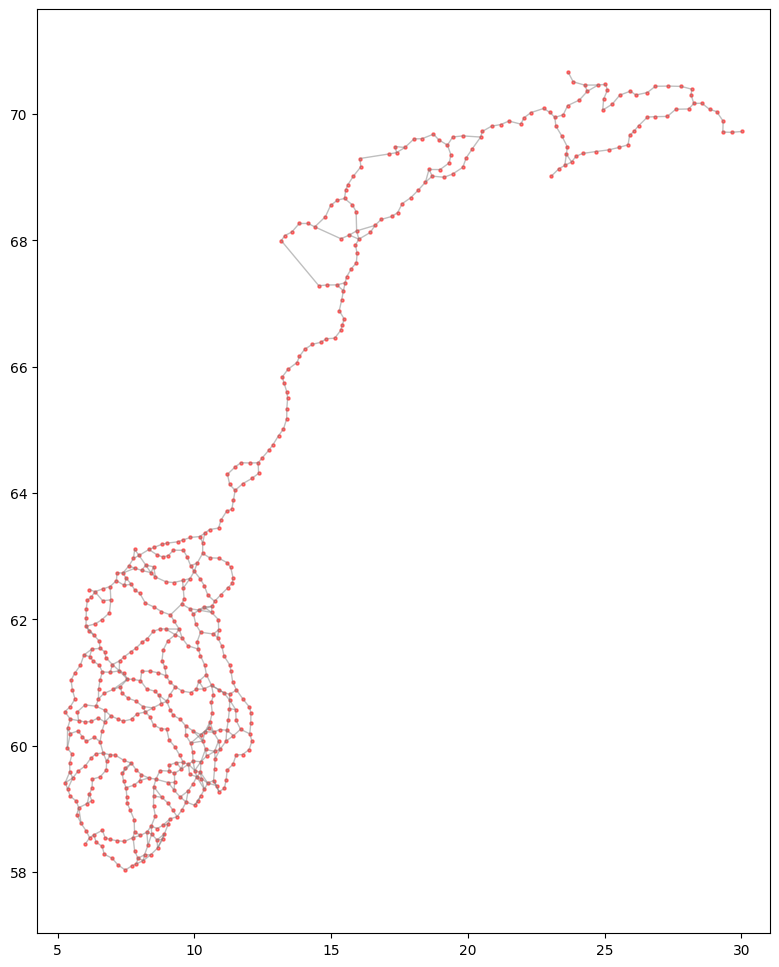

,x,y,osmid,roadclass,isBridge,isTunnel,elevation,OD,CS,merged_nodes,geometry
794436,10.733793,59.909994,794436,0,0,1,2.351,1,0,"[794436, 1393791, 1393835, 733912, 1619561, 14...",POINT (10.73379 59.90999)
1394577,10.442084,59.834063,1394577,0,0,0,106.972,0,0,"[1394577, 1393791, 1393835, 1432666, 237506, 1...",POINT (10.44208 59.83406)
1492778,10.234688,59.745743,1492778,0,0,0,11.510,1,0,"[1492778, 1432666, 237506, 237172, 1436424, 11...",POINT (10.23469 59.74574)
1613461,10.759877,59.795896,1613461,0,0,0,107.619,0,0,"[1613461, 733912, 346323, 346238, 1406120, 759...",POINT (10.75988 59.79590)
1405705,10.734618,59.626621,1405705,0,0,0,95.427,0,0,"[1405705, 1405400, 346238, 1361508, 1361404, 1...",POINT (10.73462 59.62662)


,source,target,length,geometry
0,794436,735703,11865.763083,"LINESTRING (10.73379 59.90999, 10.93659 59.94130)"
1,794436,1394577,18400.112254,"LINESTRING (10.73379 59.90999, 10.44208 59.83406)"
2,794436,1613461,12795.372148,"LINESTRING (10.73379 59.90999, 10.75988 59.79590)"
3,794436,1337200,18742.346071,"LINESTRING (10.73379 59.90999, 10.40468 59.94175)"
4,794436,492484,20506.422911,"LINESTRING (10.73379 59.90999, 10.88544 60.07765)"


Number of Nodes in Input Graph: 1745
Number of Edges in Input Graph: 2377
----------------------------------------------------------------------
Number of Nodes in Simplified: 535
Number of Edges in Simplified: 674


In [97]:
# Plot the nodes and edges geodataframes using matplotlib
fig, ax = plt.subplots(figsize=(12, 12))
edges_gdf.plot(ax=ax, linewidth=1, edgecolor='grey', alpha=0.5)
nodes_gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5) # comment this out to see just edges - some seem to not be connected(?)

# Set plot limits and display the plot
ax.set_xlim(edges_gdf.total_bounds[0]-1, edges_gdf.total_bounds[2]+1)
ax.set_ylim(edges_gdf.total_bounds[1]-1, edges_gdf.total_bounds[3]+1)
plt.show()

# Or plot like this (plotting the network)
#ox.plot_graph(M, figsize = (10, 10), node_color="red", edge_color = "gray", bgcolor = "white", node_size=10, edge_linewidth = 1)

display(nodes_gdf.head())
display(edges_gdf.head())

print("Number of Nodes in Input Graph:", P.number_of_nodes())
print("Number of Edges in Input Graph:", P.number_of_edges())
print('----------------------------------------------------------------------')
print("Number of Nodes in Simplified:", M.number_of_nodes())
print("Number of Edges in Simplified:", M.number_of_edges())

Check length distribution:

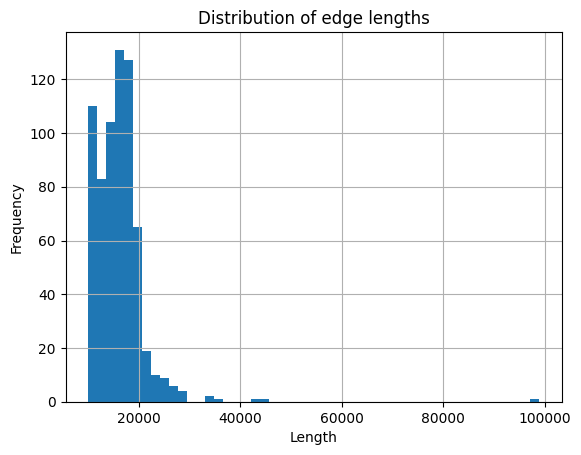

Looks good! (Y)


In [90]:
# Plot a histogram of the length column
fig, ax = plt.subplots()
edges_gdf.hist(column='length', bins=50, ax=ax)
ax.set_xlabel('Length')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of edge lengths')
plt.show()
print('Looks good! (Y)')

*(The function below is suppose to connect the network if there are any edges that dont connect. <br>*
*In our case there are no edges that are not connected, so not sure if this function works or not.)*

In [37]:
""" def reconnect_disconnected_edges_v2(G, threshold=10000):
    G_connected = G.copy()

    def find_nearest_intersection(node):
        min_distance = float('inf')
        nearest_intersection = None
        for candidate_node in G_connected.nodes:
            if G_connected.degree[candidate_node] > 2:
                dist = distance((G_connected.nodes[node]['y'], G_connected.nodes[node]['x']),
                                (G_connected.nodes[candidate_node]['y'], G_connected.nodes[candidate_node]['x'])).m
                if dist < min_distance:
                    min_distance = dist
                    nearest_intersection = candidate_node
        return nearest_intersection, min_distance

    disconnected_edges = [(u, v) for u, v in G_connected.edges if G_connected.degree[u] == 1 and G_connected.degree[v] == 1]

    for u, v in tqdm(disconnected_edges, desc='Reconnecting edges'):
        nearest_intersection_u, dist_u = find_nearest_intersection(u)
        nearest_intersection_v, dist_v = find_nearest_intersection(v)

        if dist_u < threshold and dist_v < threshold:
            edge_data = G_connected.edges[u, v].copy()
            G_connected.remove_edge(u, v)
            G_connected.add_edge(nearest_intersection_u, nearest_intersection_v, **edge_data)

    return G_connected """


In [ ]:
#M = reconnect_disconnected_edges_v2(M, threshold=10000)

In [ ]:
""" # Store node attributes in a dictionary
node_attrs = {}
for node, attrs in M.nodes(data=True):
    node_attrs[node] = attrs

# Create a DataFrame from the node attributes
node_df = pd.DataFrame.from_dict(node_attrs, orient='index')

# Convert the edge data to a pandas DataFrame
edge_data = M.edges(data=True)
edge_df = pd.DataFrame(edge_data, columns=['source', 'target', 'data_dict'])

# Extract the data into separate columns
edge_df = pd.concat([edge_df.drop('data_dict', axis=1), edge_df['data_dict'].apply(pd.Series)], axis=1)

def create_edge_geometry(u, v):
    u_coords = (G_multigraph.nodes[u]['x'], G_multigraph.nodes[u]['y'])
    v_coords = (G_multigraph.nodes[v]['x'], G_multigraph.nodes[v]['y'])
    return LineString([u_coords, v_coords])

edge_df['geometry'] = edge_df.apply(lambda row: create_edge_geometry(row['source'], row['target']), axis=1)

# create geometry points from x and y columns
geometry = [Point(xy) for xy in zip(node_df['x'], node_df['y'])]
# add geometry column to dataframe
node_df['geometry'] = geometry
nodes_gdf = gpd.GeoDataFrame(node_df, geometry="geometry")
edges_gdf = gpd.GeoDataFrame(edge_df, geometry="geometry")

nodes_gdf.crs = {'init': 'epsg:4326'}
edges_gdf.crs = {'init': 'epsg:4326'} """

In [ ]:
""" # Plot the nodes and edges geodataframes using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
edges_gdf.plot(ax=ax, linewidth=1, edgecolor='grey', alpha=0.5)
nodes_gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5) # comment this out to see just edges - some seem to not be connected(?)

# Set plot limits and display the plot
ax.set_xlim(edges_gdf.total_bounds[0]-1, edges_gdf.total_bounds[2]+1)
ax.set_ylim(edges_gdf.total_bounds[1]-1, edges_gdf.total_bounds[3]+1)
plt.show()

# Or plot like this (plotting the network)
#ox.plot_graph(M, figsize = (10, 10), node_color="red", edge_color = "gray", bgcolor = "white", node_size=10, edge_linewidth = 1)

display(nodes_gdf.head())
display(edges_gdf.head())

print("Number of Nodes in Input Graph:", P.number_of_nodes())
print("Number of Edges in Input Graph:", P.number_of_edges())
print('----------------------------------------------------------------------')
print("Number of Nodes in Simplified:", M.number_of_nodes())
print("Number of Edges in Simplified:", M.number_of_edges()) """

### Save geodataframes as csv and graph as pickle object:

In [96]:
# Graph, pickle object:
#path = '/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling/Simplified_10kmRadius.pickle'
#nx.write_gpickle(M.to_undirected(), path)
# Node GeoDataFrame:
nodes_gdf.to_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling/nodes_Simplified_10km_gdf.csv', index=False) # specify the filename and set index=False to exclude the index from the output
# Edge GeoDataFrame:
edges_gdf.to_csv('/Users/filipmoennilsen/Documents/Skolearbeid/BI_Master_BAN/4. Semester/Master_Thesis/Master_Python/roadNetwork_Venv/PythonFiles/NetworkModelling_Final/3_outputFromNetworkModelling/edges_Simplified_10km_gdf.csv', index=False) # specify the filename and set index=False to exclude the index from the output
